# Relevant imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.signal import argrelextrema
import math
import numpy as np
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  
import pandas as pd
import matplotlib.ticker as ticker

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['font.family']='stix'
plt.rcParams['text.usetex']=True
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150

$..................................................................................$

In [9]:
from classy import Class

# Define your cosmology (what is not specified will be set to CLASS default parameters)
params = {
    'output': 'mPk',
    'omega_b': 0.022068,
    'omega_cdm': 0.,
    'omega_dmeff': 0.1199}

# Create an instance of the CLASS wrapper
cosmo = Class()

# Set the parameters to the cosmological code
cosmo.set(params)

cosmo.compute()


TypeError: get_pk() takes exactly 5 positional arguments (0 given)

$..................................................................................$

$..................................................................................$

# Semi-analytical business

### Various constants

http://pdg.lbl.gov/2014/reviews/rpp2014-rev-astrophysical-constants.pdf

https://arxiv.org/pdf/1904.10000

https://arxiv.org/pdf/1502.01589.pdf

In [3]:
# Constants
h = 0.6727
H0=67.27
Omega_m = (0.1199)/(h**2)
Omega_b = 0.05
Omega_rad=10e-5
p_crit=4.755e-6
rho_crit = 1.256*10**11*Omega_m
p_b = Omega_b*p_crit
T0 = 2.7255
kb = 8.617333262145e-5
T_0 = kb*T0*1e-9
m_p=0.93827231
Y_p=0.75

# Factors to satisfy units
k_crit_conversionFactor=3.33333333e-6
R_x_conversionFactor=9.258e29

# Mass/sigma arrays
masses = np.array([1e-4,1e-3,1e-2,1e-1,1.,10.])
sigma = np.zeros(len(masses))
sigma_array = np.logspace(-10,-30,200)

---

### Relevant functions

https://arxiv.org/pdf/1801.08609.pdf

$ N_0 =  2^{(5+n)/2}\Gamma(3+n/2)/(3\sqrt{\pi})$

In [3]:
def N_0(n):
    return pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))

---

http://sro.sussex.ac.uk/id/eprint/46339/1/MNRAS-2012-Schneider-684-98.pdf

$M_{hm} = \frac{4\pi\bar{\rho}}{3}\big(\frac{\lambda_{hm}}{2}\big)^3$

$\qquad = \frac{4\pi\bar{\rho}}{3}\big(\frac{\pi}{hk_{hm}}\big)^3$

$\therefore k_{hm} = \frac{\pi}{h}\big(\frac{4\pi\bar{\rho}}{3M_{hm}}\big)^{1/3}$

In [4]:
def mhm2khm(Mhm):
    return np.pi/h*(((4.*np.pi*rho_crit)/(3*Mhm))**(1./3.))

---

https://arxiv.org/pdf/1808.00001.pdf

$R_x = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_b}{m_p}+\frac{T_{\chi}}{m_{\chi}}\Big)^{\frac{1+n}{2}}$


In [5]:
def R_x(sigma_0, m_x, n):
    return N_0(n)*Y_p*p_b*R_x_conversionFactor*(sigma_0/(m_x+m_p))*(pow((T_0/m_x)+(T_0/m_p),((1.+n)/2.)))

---

https://arxiv.org/pdf/1904.10000

$aH = R_{\chi}(m_{\chi}/(m_{\chi}+m_p))$

Note that $aH \sim z$ and $R_{\chi} \sim z^{n+5/2}$ such that

$zH_0\sqrt{\Omega_{rad}} = R_{\chi}(m_{\chi}/(m_{\chi}+m_p))z^{n+5/2}$

$\therefore z = ((m_{\chi}+m_p)H_0\sqrt{\Omega_{rad}}/R_{\chi}m_{\chi})^{2/n+3}$

In [6]:
def z_th(sigma_0,m_x,n):
    return ((H0*np.sqrt(Omega_rad)*(m_x+m_p))/(R_x(sigma_0,m_x,n)*m_x))**(2./(n+3.))

---

https://arxiv.org/pdf/1904.10000

$aH = R_{\chi} = \frac{N_0a\rho_bY_p\sigma_0}{m_{\chi}+m_p}\Big(\frac{T_b}{m_p}+\frac{T_{\chi}}{m_{\chi}}\Big)^{\frac{1+n}{2}}$

Note that $aH \sim z$, $a\bar{\rho} \sim z^2$, $T_b \sim z$ and $T_{\chi} \sim z^2/z_{th}$, such that

$\frac{H_0\sqrt{\Omega_{rad}}(m_{\chi}+m_p)}{N_0Y_p\rho_b\sigma_0} = z^2/z \big(\frac{T_0z}{m_p}+\frac{T_0z^2}{z_{th}m_{\chi}}\big)^{n+1/2}$

$0 = z \big(\frac{T_0z}{m_p}+\frac{T_0z^2}{z_{th}m_{\chi}}\big)^{n+1/2} - \frac{H_0\sqrt{\Omega_{rad}}(m_{\chi}+m_p)}{N_0Y_p\rho_b\sigma_0}$

Solving the above for $z$ yields $z_{kin}$

In [7]:
def z_kin(sigma_0,m_x,n):
    return fsolve(lambda z: z * ((T_0*z**2)/(z_th(sigma_0,m_x,n)*m_x) + (T_0*z_th(sigma_0,m_x,n))/m_p)**((n+1.)/2.) - (H0*np.sqrt(Omega_rad)/(N_0(n)*Y_p*p_b*R_x_conversionFactor))*(m_x+m_p)/sigma_0,z_th(sigma_0,m_x,n)/2.)    

---

https://arxiv.org/pdf/1904.10000

$k_{crit} = 2aH = 2H_0\sqrt{\Omega_{rad}}z_{kin}^2/z_{kin} = 2H_0\sqrt{\Omega_{rad}}z_{kin}$

In [8]:
# Equation 4
def sigma2k(sigma_0,m_x,n):
    return 2.*(H0*np.sqrt(Omega_rad)*z_kin(sigma_0,m_x,n))*3.33e-6

---

### $\sigma_0$ limits

In [9]:
def sig(klimit,n):
    sigma = []
    for i in range(len(masses)):
        sigma.append(sigma_array[np.argmin(np.abs(sigma2k(sigma_array,masses[i],n)-h*klimit))])
    return np.array(sigma)

def sigma_vs_mx(klimit):
    return hv.Curve((masses, sig(klimit)))

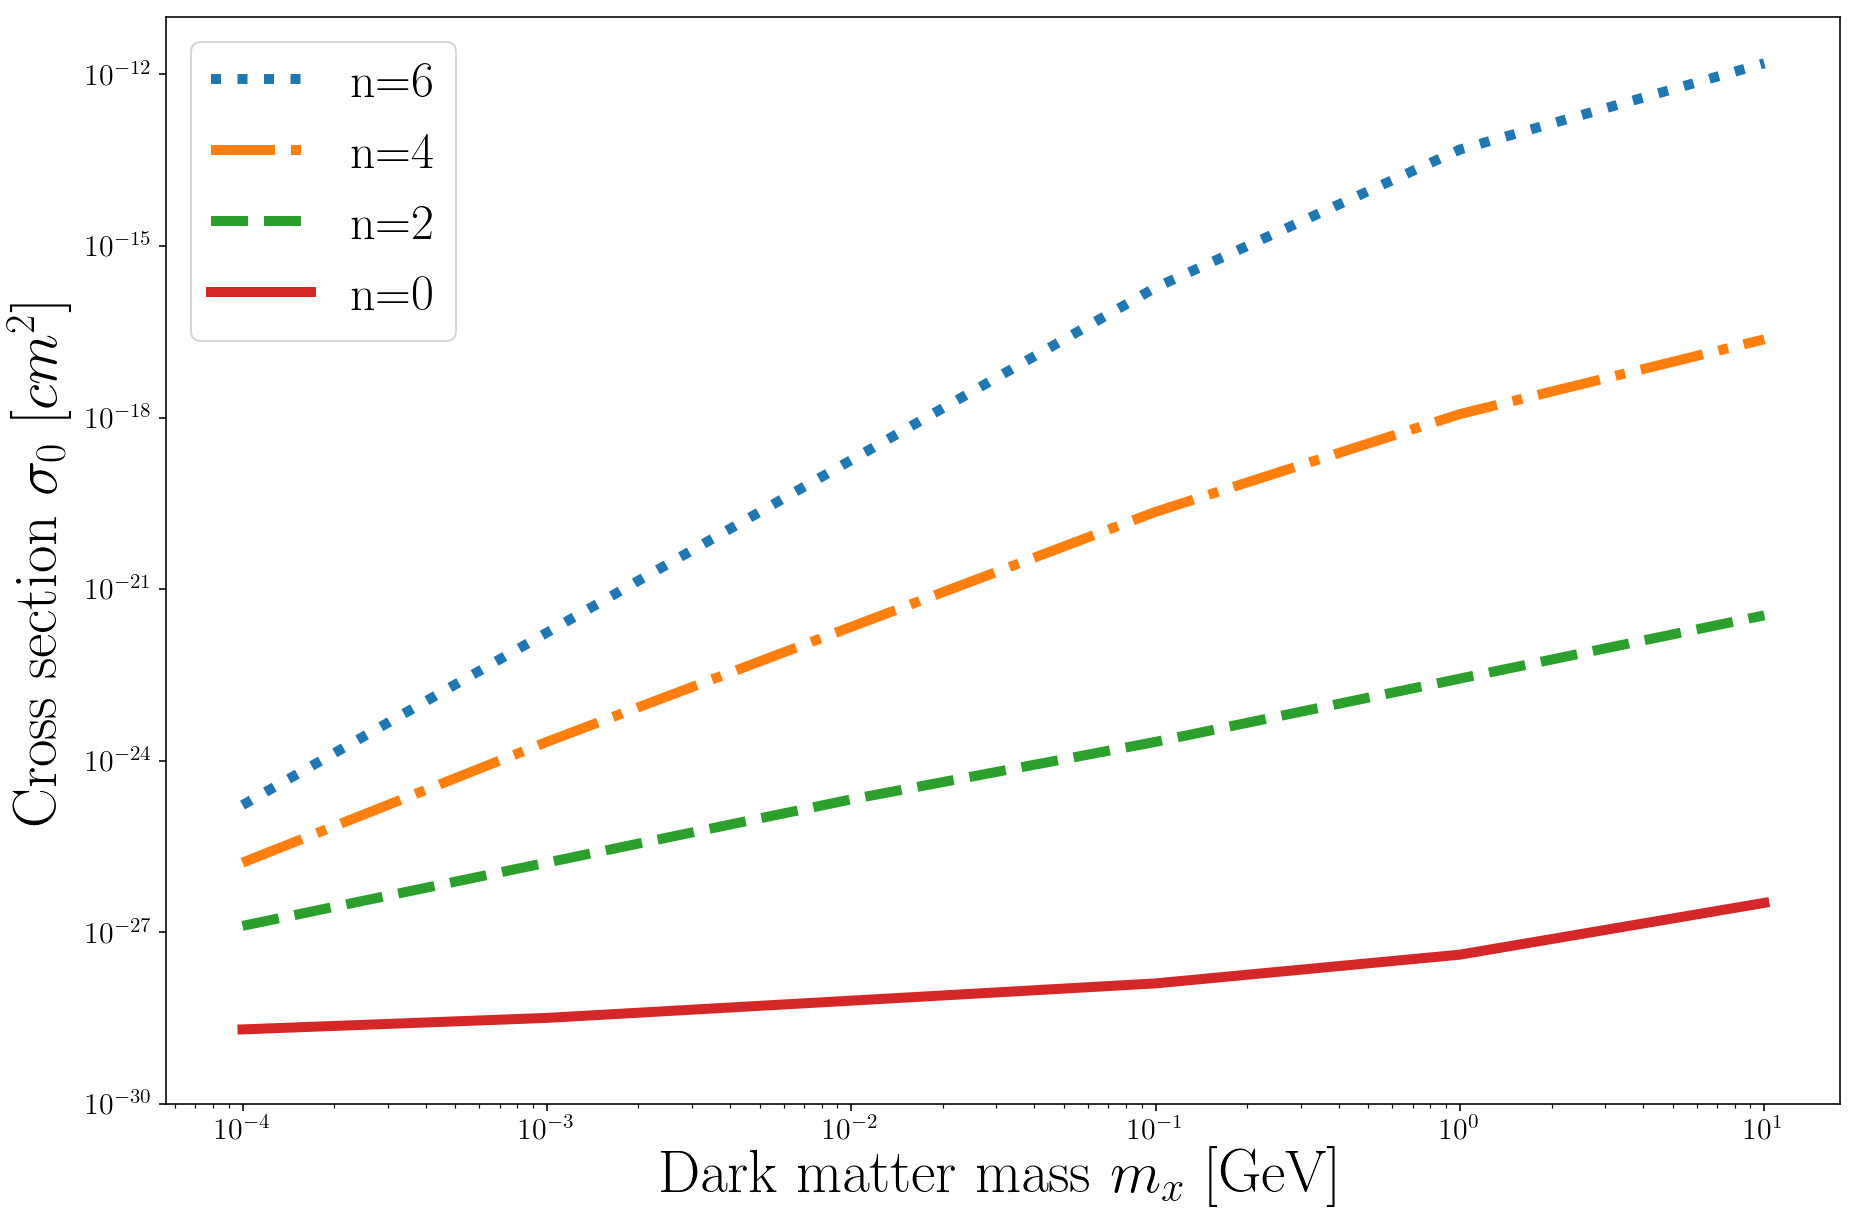

In [10]:
klim = mhm2khm(3*10**8)
# klim=0.1
plt.figure(figsize=(15,10))

plt.loglog(masses, sig(klim,6.), label="n=6",linewidth=5,linestyle=':')
plt.loglog(masses, sig(klim,4.), label="n=4",linewidth=5,linestyle='-.')
plt.loglog(masses, sig(klim,2.), label="n=2",linewidth=5,linestyle='--')
plt.loglog(masses, sig(klim,0.), label="n=0",linewidth=5)

# plt.title(r"Analytical", fontsize=20)
plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]", fontsize=30)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]", fontsize=30)
plt.legend(fontsize=25)
plt.tick_params(labelsize=15)
plt.ylim(1e-30,1e-11)

plt.savefig("analytical.png")

$..................................................................................$

$..................................................................................$

$..................................................................................$

# Numerical business

In [4]:
# masses_test = [1e-4,1e-3,1e-2,1e-1,1.,10.]
masses_test = [1]
smallSigs = np.logspace(-20,-30,100)
cmapSigs = np.logspace(-20,-30,246)
largeSigs = np.logspace(-10,-30,100)
npow=2

---

### Generate ICs

In [12]:
def make_inis(ini_base_file='class/inis/dmeff_base.ini',
              base_inis_path='class/inis/',
              class_runner_path = 'class/',
              npow=0,
              masses=masses_test,
              sigmas=smallSigs,
              output_path='pk_output',
              sh_file='class/run_classes.sh'):
    
    sh_file = class_runner_path+'run_classes.sh'

    fin =  open(ini_base_file, 'r')
    base_content = fin.read()
    fin.close()
    
    fout_sh = open(sh_file, 'w')

    for m in masses:
        if m<1:
            sigmas = smallSigs
        else:
            sigmas = largeSigs
            
        for sigma in smallSigs:
            filename = 'n{}_m{}_s{}.ini'.format(npow,m,sigma)
            fout_sh.write('./class ' + 'inis/{}\n'.format(filename))

            fout = open(base_inis_path + filename, 'w')
            fout.write(base_content)
            fout.write('\n')

            npow_line = 'npow_dmeff = {}\n'.format(npow)
            fout.write(npow_line)
            m_line = 'm_dmeff = {}\n'.format(m)
            fout.write(m_line)
            sigma_line = 'sigma_dmeff = {}\n'.format(sigma)
            fout.write(sigma_line)
            if npow<0:
                vel_line = 'Vrel_dmeff_rate = 30\n' #sets to DBK case.
                fout.write(vel_line)
            root_line = 'root = {}/n{}_m{}_s{}_\n'.format(output_path,npow,m,sigma)
            fout.write(root_line)
            
    fout_sh.close()

In [13]:
make_inis(npow=4)

From the command line, run:

chmod +x run_classes.sh

bash run_classes.sh

---

### $\sigma_0$ limits

In [14]:
def calculate_kcuts(npow=0, m=1e-3, z='z1',sigmas=smallSigs,
           pk_root='class/pk_output/', upper_cut=66, lower_cut=1, reduction_factor=0.75):
    
    data0 = np.loadtxt(pk_root + 'lcdm_{}_pk.dat'.format(z))
    ks = data0[:,0]
    pk0 = data0[:,1]
    khms = []
    ss = []
    
    if m<1:
        sigmas = smallSigs
    else:
        sigmas = largeSigs
        
    for i,sigma in enumerate(sigmas):
        filename = pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z)
        try:
            data = np.loadtxt(filename)
        except:
            continue
        pk = data[:,1]
        ind = (np.abs(np.abs((pk0-pk)/pk0) - reduction_factor)).argmin()
        if ks[ind]>upper_cut or ks[ind]<lower_cut:
            continue
        khms.append(ks[ind])
        ss.append(sigmas[i])
    
    try:
        p = np.polyfit(np.log10(ss), np.log10(khms), 1)
    except:
        return -1
    
    return np.array(ss),np.array(khms),p

In [15]:
def fit_fun(x,p):
    pp = p[0]*np.log10(x) + p[1]
    return np.power(10,pp)

In [16]:
def sigma0_limit(kcut, masses=masses_test,
                npow=0, z=0,reduction_factor=0.25,
                ymax=1e-26,ymin=1e-31,plot_ks=True):
    
    masses = np.array(masses)
    sigmas = np.zeros(len(masses))

    for i,m in enumerate(masses):
        ks_filename = 'data/ks_{}_z{}_n{}_m{}.txt'.format(reduction_factor,z,npow,m)
        np.loadtxt(ks_filename)
        data = np.loadtxt(ks_filename)
        ss = data[:,0]
        ks = data[:,1]
        p = np.polyfit(np.log10(ks), np.log10(ss), 1)
        sigmas[i] = fit_fun(kcut,p)
                  
    return masses,sigmas

In [17]:
npow_=0

In [18]:
for m in masses_test:
    if calculate_kcuts(npow=npow_, m=m, z='z1') == -1:
        continue
    sigmas, kcuts, p = calculate_kcuts(npow=npow_, m=m, z='z1')

In [19]:
sigmas_ref = np.logspace(-10,-30,1000)
for m in masses_test:
    ks_filename = 'data/ks_0.25_z0_n{}_m{}.txt'.format(npow_,m)
    if calculate_kcuts(npow=npow_, m=m, z='z1') == -1:
        continue
    sigmas, kcuts, p = calculate_kcuts(npow=npow_, m=m, z='z1')
    ks = fit_fun(sigmas_ref,p)
    np.savetxt(ks_filename, np.vstack((sigmas_ref, ks)).T)

In [20]:
masses0,sigmas0=sigma0_limit(kcut=36,npow=0)
masses2,sigmas2=sigma0_limit(kcut=36,npow=2)
masses4,sigmas4=sigma0_limit(kcut=36,npow=4)
masses6,sigmas6=sigma0_limit(kcut=36,npow=6)

IOError: data/ks_0.25_z0_n2_m1.txt not found.

In [ ]:
plt.figure(figsize=(15,10))

plt.loglog(masses6,sigmas6, label="n=6",linewidth=5,linestyle=':')
plt.loglog(masses4,sigmas4, label="n=4",linewidth=5,linestyle='-.')
plt.loglog(masses2,sigmas2, label="n=2",linewidth=5,linestyle='--')
plt.loglog(masses0,sigmas0, label="n=0",linewidth=5)

plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]", fontsize=40)
plt.xlabel(r"Dark matter mass $m_x$ [GeV]", fontsize=40)
plt.legend(fontsize=30)
plt.tick_params(labelsize=25)
plt.ylim(1e-30,1e-11)

plt.savefig("numerical.png")

---

### $P(k)_{idm}/P(k)_{cdm}$

In [21]:
def findLocalMins(arr):
    mins = []
    i=0
    while i < len(arr):
        try:
            if (arr[i-3]-arr[i])>0.01 and (arr[i+3]-arr[i])>0.01:
                mins.append(i)
                i+=3
            i+=1
        except:
            i+=1
            continue
         
    return mins

In [292]:
def findLocalMaxs(arr):
    maxs = []
    i=0
    while i < len(arr):
        try:
            if (arr[i]-arr[i-3])>0.01 and (arr[i]-arr[i+3])>0.01:
                maxs.append(i)
#                 i+=3
            i+=1
        except:
            i+=1
            continue
                
    return maxs

In [518]:
def show_pk(npow=0,m=0.0001,sigmas=smallSigs,z='z1',
           pk_root='class/pk_output/',
            filename=None,lcdm_filename='lcdm_z1_pk.dat',label='',
           f=None,ax=None,xmin=0,xmax=20,ymin=-1.0,ymax=1e3,
           show_kcut=True,pfit=None, relative=True,boost_factor=1.):
    
    data0 = np.loadtxt(pk_root + lcdm_filename)
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    k1 = []
    k2 = []
    sigs = []
    
    if filename is None:
        for i,sigma in enumerate(sigmas):
            
            # selection criteria
#             if i==1:
#                 clr = 'steelblue'
#             elif i==2:
#                 clr = 'salmon'
#             else:
#                 continue
            
            # colors for peak plot
            if i<10:
                col = 'darkred'
            if i>10 and i<20:
                col = 'chocolate'
            if i>20 and i<30:
                col = 'orange'
            if i>30 and i<40:
                col = 'gold'
            if i>40:
                col = 'yellow'
            
            # pk data from class for given mass, sigma, power
            filename = pk_root + 'n{}_m{}_s{}_{}_pk.dat'.format(npow,m,sigma,z)
            np.loadtxt(filename)
            data = np.loadtxt(filename)
            pk = data[:,1]
            
            # determine peaks/troughs of transfer
            a = pk/pk0
            mins = findLocalMins(a)
            maxs = findLocalMaxs(a)

            try:
                posOnly = (((pk)/pk0)-0.25)>0
                ind = int((mins[1]-maxs[0])/4)

                peaks1D = []
                for j in range(len(maxs)):
                    peaks1D.append(pk[maxs[j]]/pk0[maxs[j]])
                peaks2D.append(peaks1D)
                
                k1.append(ks[np.argmin(posOnly)])
                k2.append(ks[mins[1]-ind])
                sigs.append(sigma)
            
                clr = (math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10,1-math.sqrt((i+1.))/10)
                lbl = "$\sigma_0=$"+str('{:.1e}'.format(float(sigma)))+r"$\textrm{ cm}^2$"
#                 plt.plot(ks,pk,linewidth=3.5,linestyle='-',color=clr,label=lbl)
#                 plt.plot(ks,pk0,linewidth=3.5,linestyle='-',color='r',label=lbl)
                plt.plot(ks,pk/pk0,linewidth=1.5,linestyle='-',color=clr,label=lbl)
#                 break
            except:
                continue

    k1 = np.array(k1)
    k2 = np.array(k2)
    sigs = np.array(sigs)
    
    return k1,k2,sigs

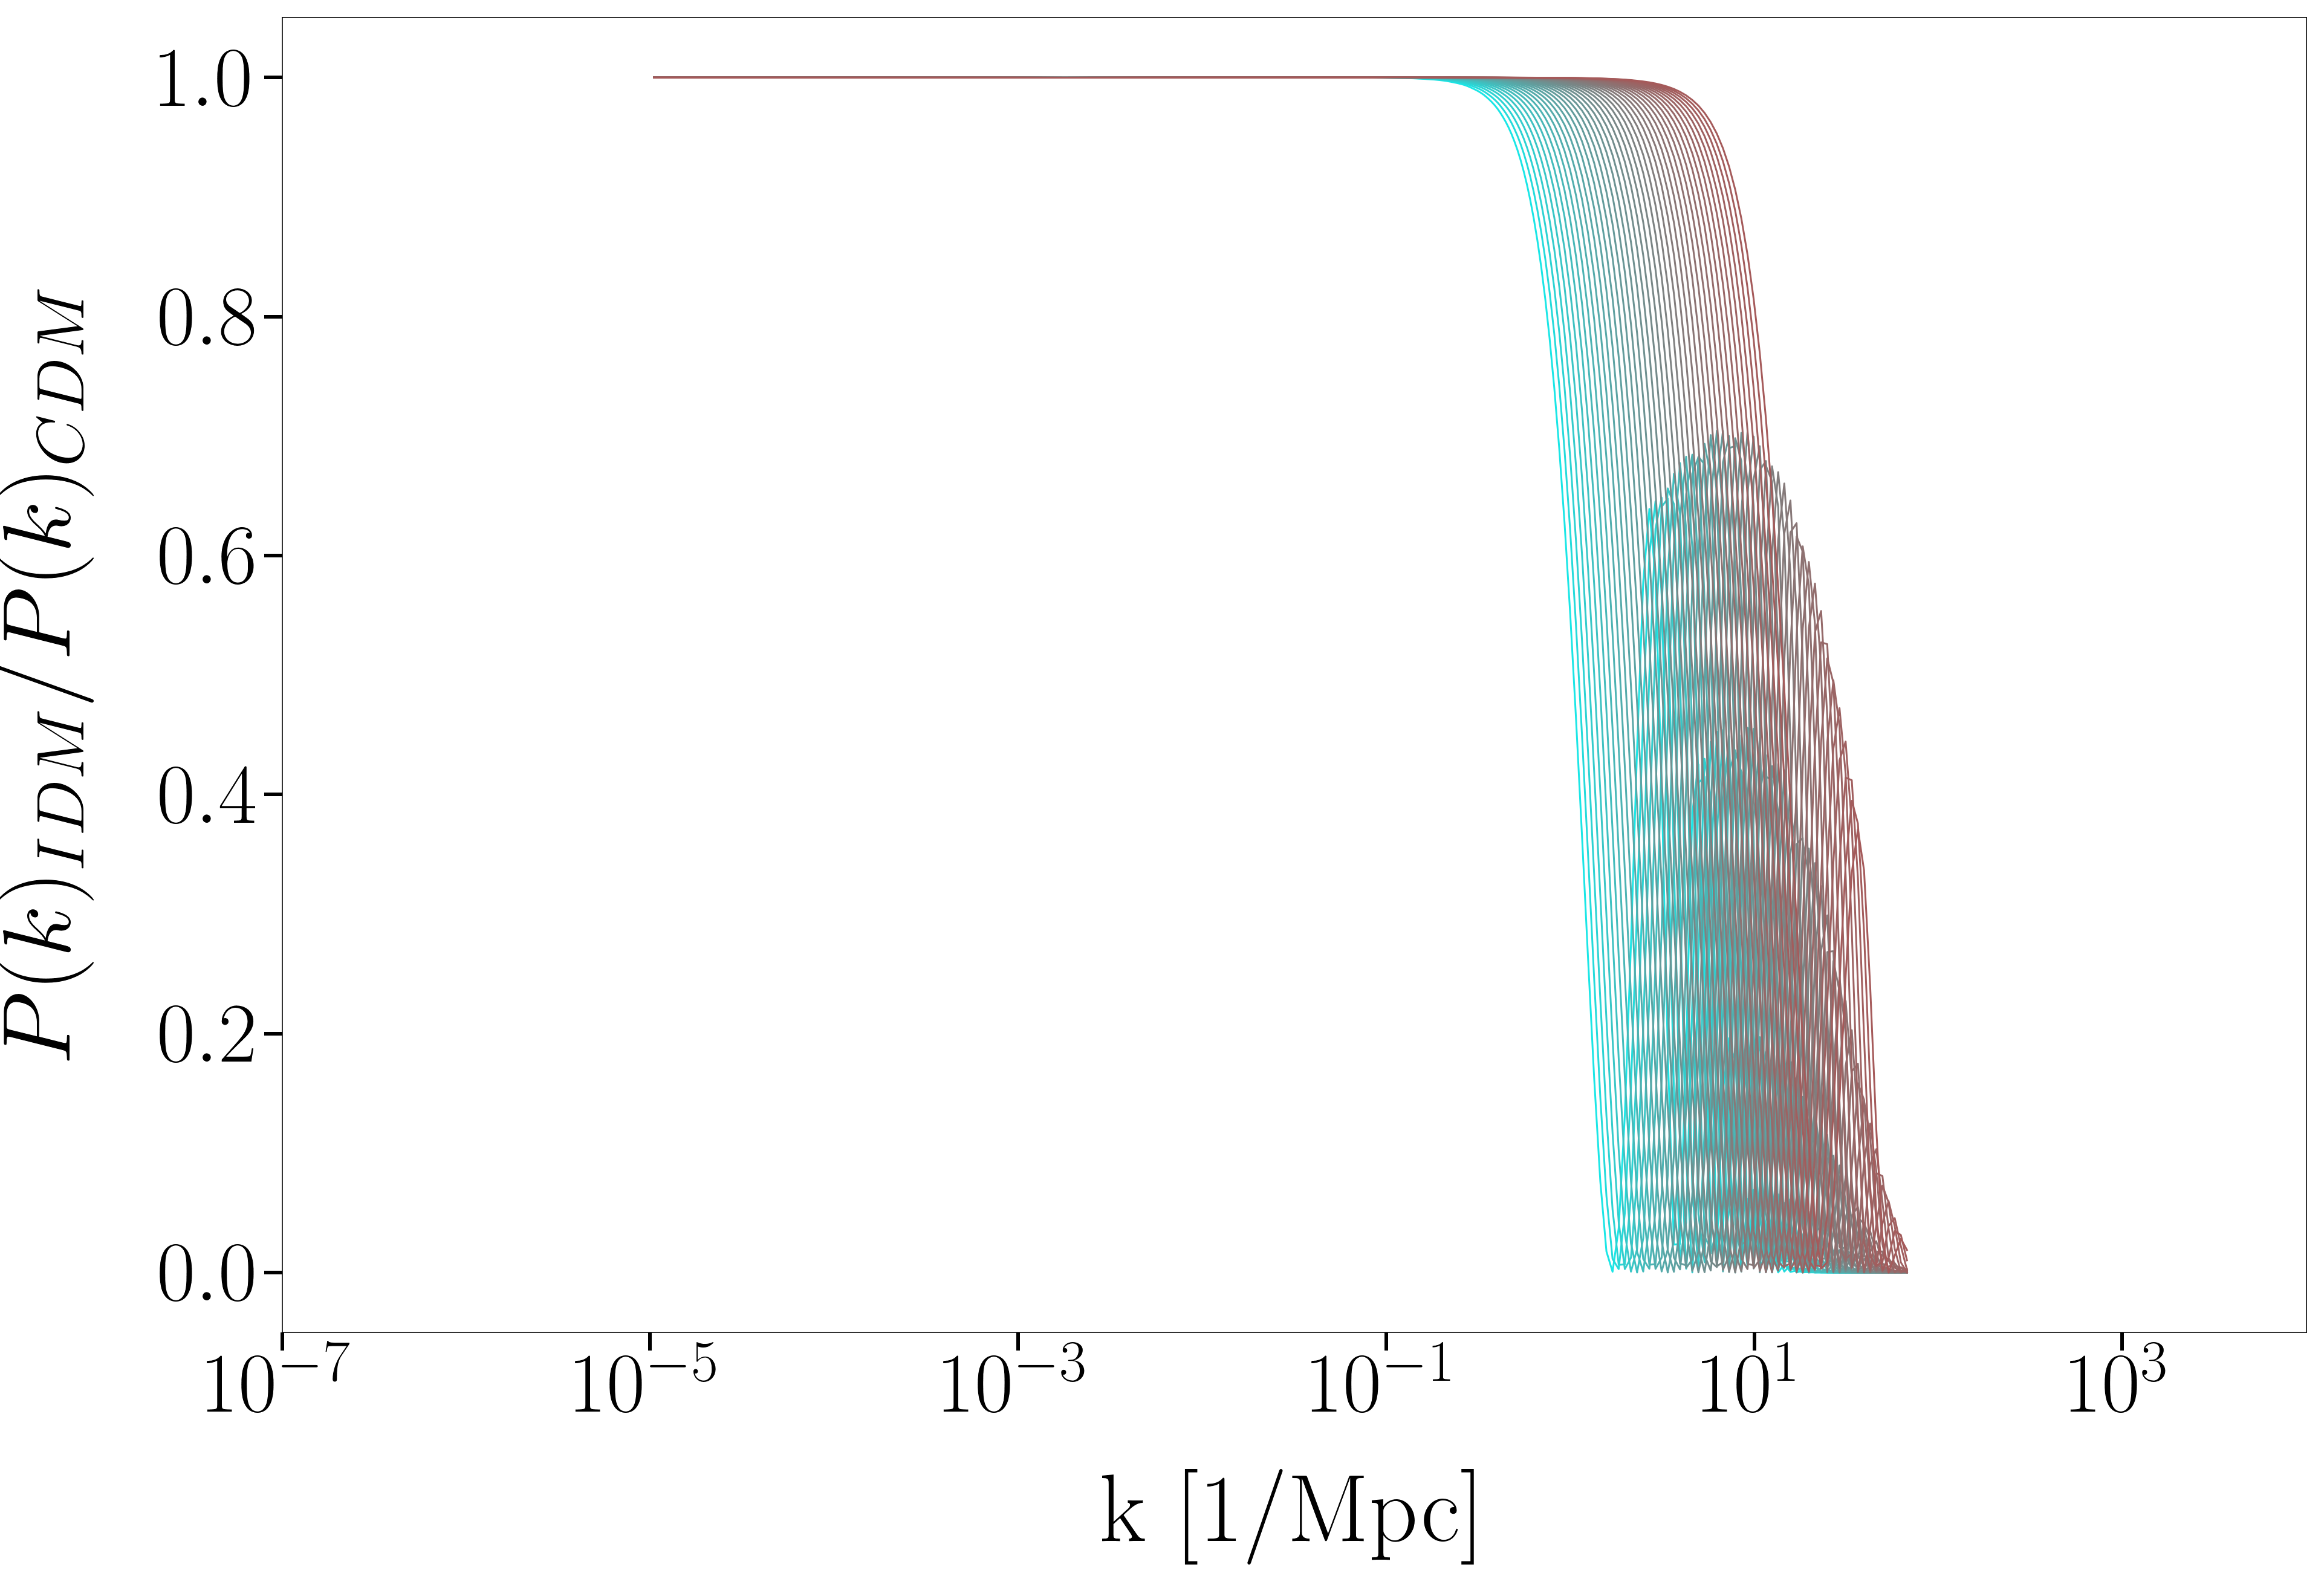

In [520]:
plt.figure(figsize=(30,20))    
plt.xscale('log')
plt.xlabel('k [1/Mpc]',fontsize=30)
plt.ylabel('P(k) residual',fontsize=30)
plt.xlim(1e-7,1e4)
#     plt.legend(fontsize=58)
plt.ylabel(r"$P(k)_{IDM}/P(k)_{CDM}$", fontsize=80,labelpad=45)
plt.xlabel(r"k [1/Mpc]", fontsize=80, labelpad=30)
plt.tick_params(labelsize=70,length=15,width=3)
# plt.savefig("pk{}some_secondDownCrossing.pdf".format(npow),dpi=1000)
    
# k1_0,k2_0,sigs_0 = show_pk(npow=0,label="n=0")
k1_2,k2_2,sigs_2 = show_pk(npow=4,label="n=2")
# k1_4,k2_4,sigs_4 = show_pk(npow=4,label="n=4")
# k1_6,k2_6,sigs_6 = show_pk(npow=6,label="n=6")

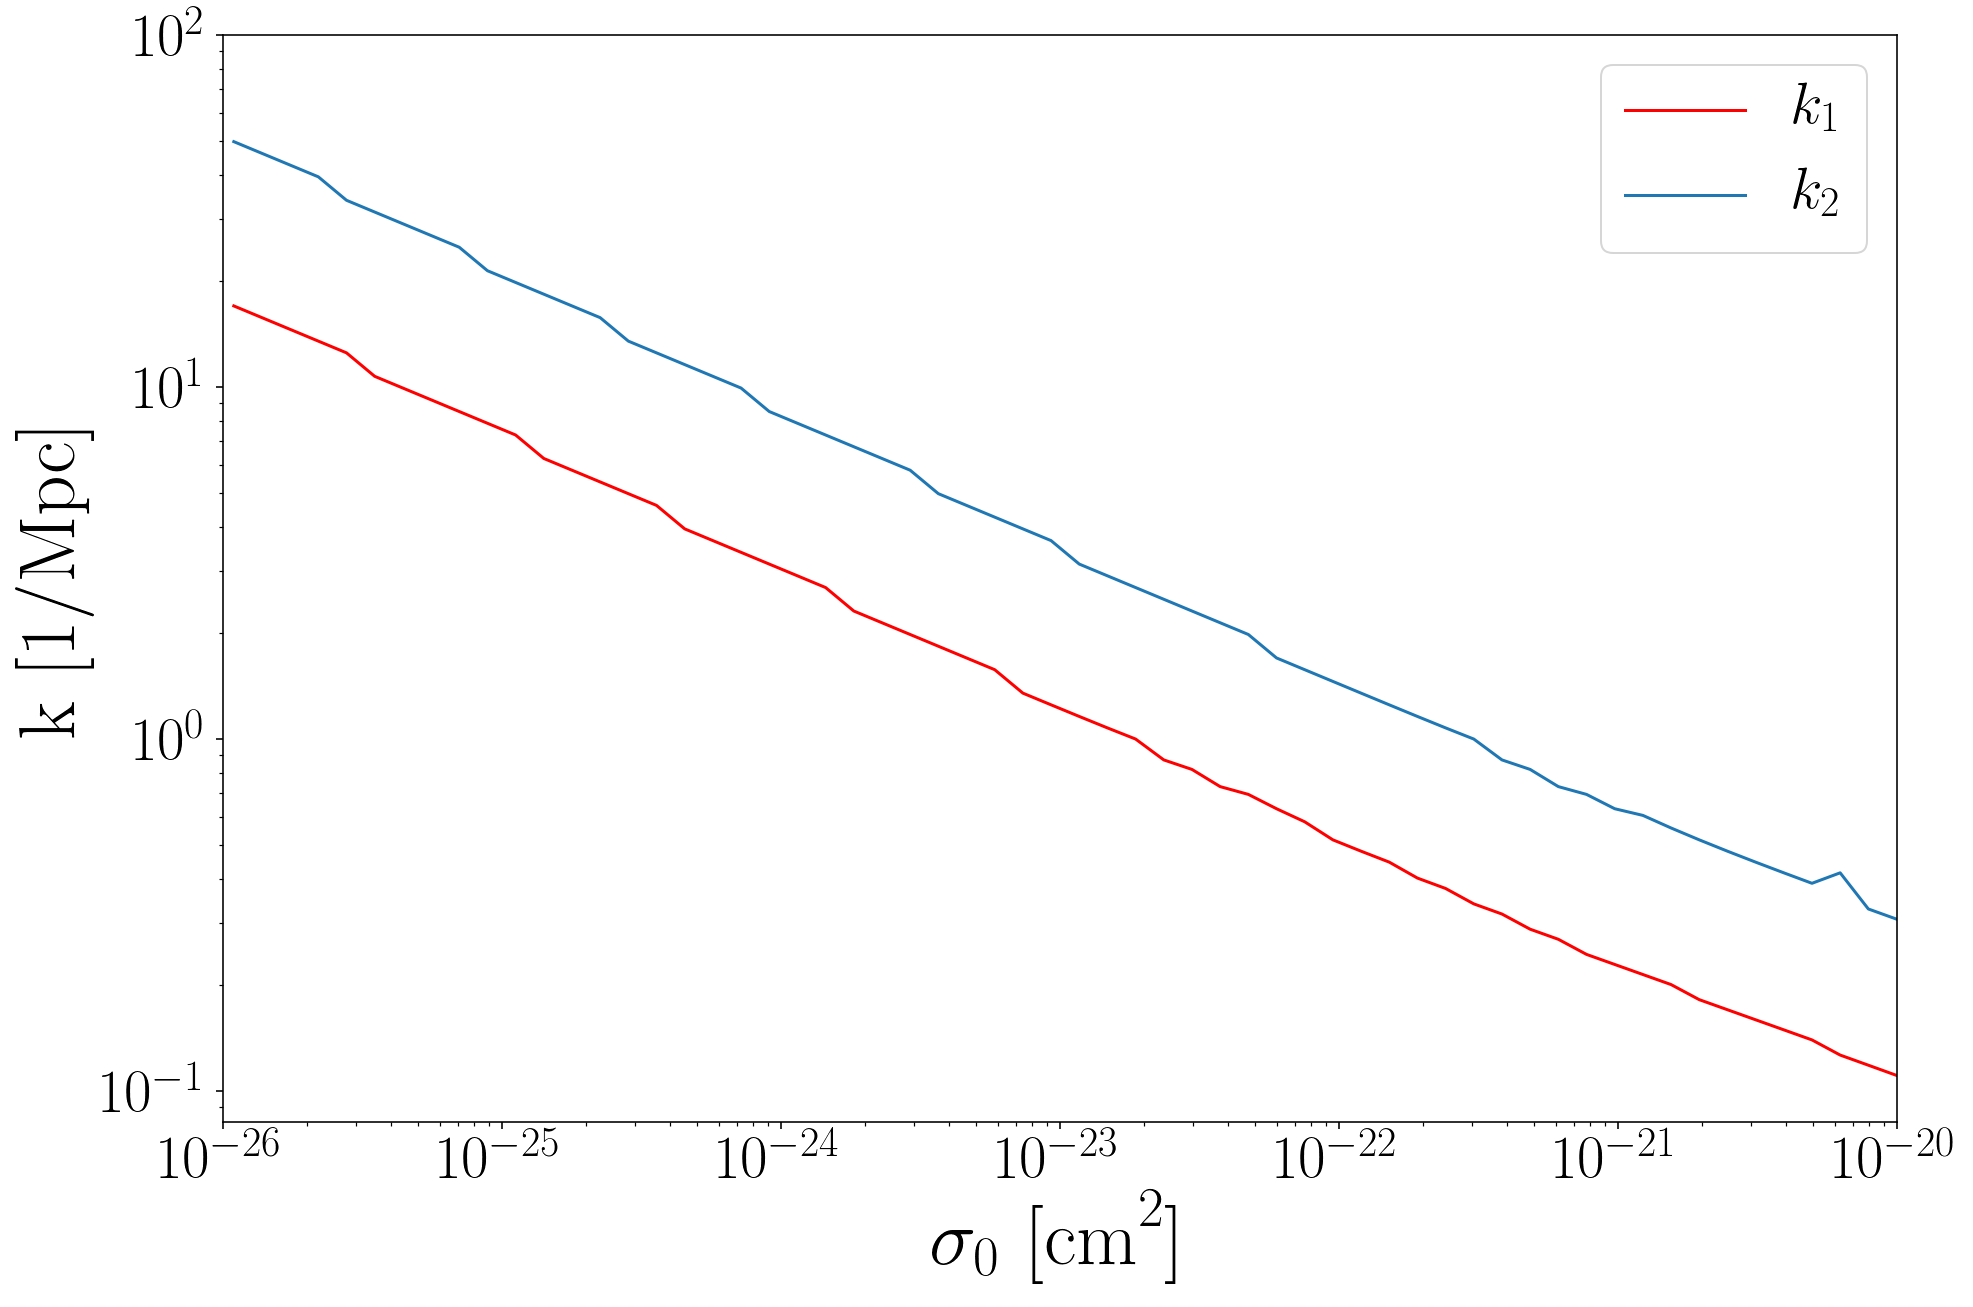

In [34]:
plt.figure(figsize=(15,10))    
plt.loglog(sigs_2,k1_2,color='r',label="$k_1$")
plt.loglog(sigs_2,k2_2,label='$k_2$')
plt.xlim(1e-26,1e-20)
plt.xticks(fontsize=30)
plt.yticks([1e-1,1e0,1e1,1e2],fontsize=30)
plt.xlabel("$\sigma_0$"+r"$\textrm{ [cm}^2]$"
,fontsize=40)
plt.ylabel('k [1/Mpc]',fontsize=40)
plt.legend(fontsize=30)

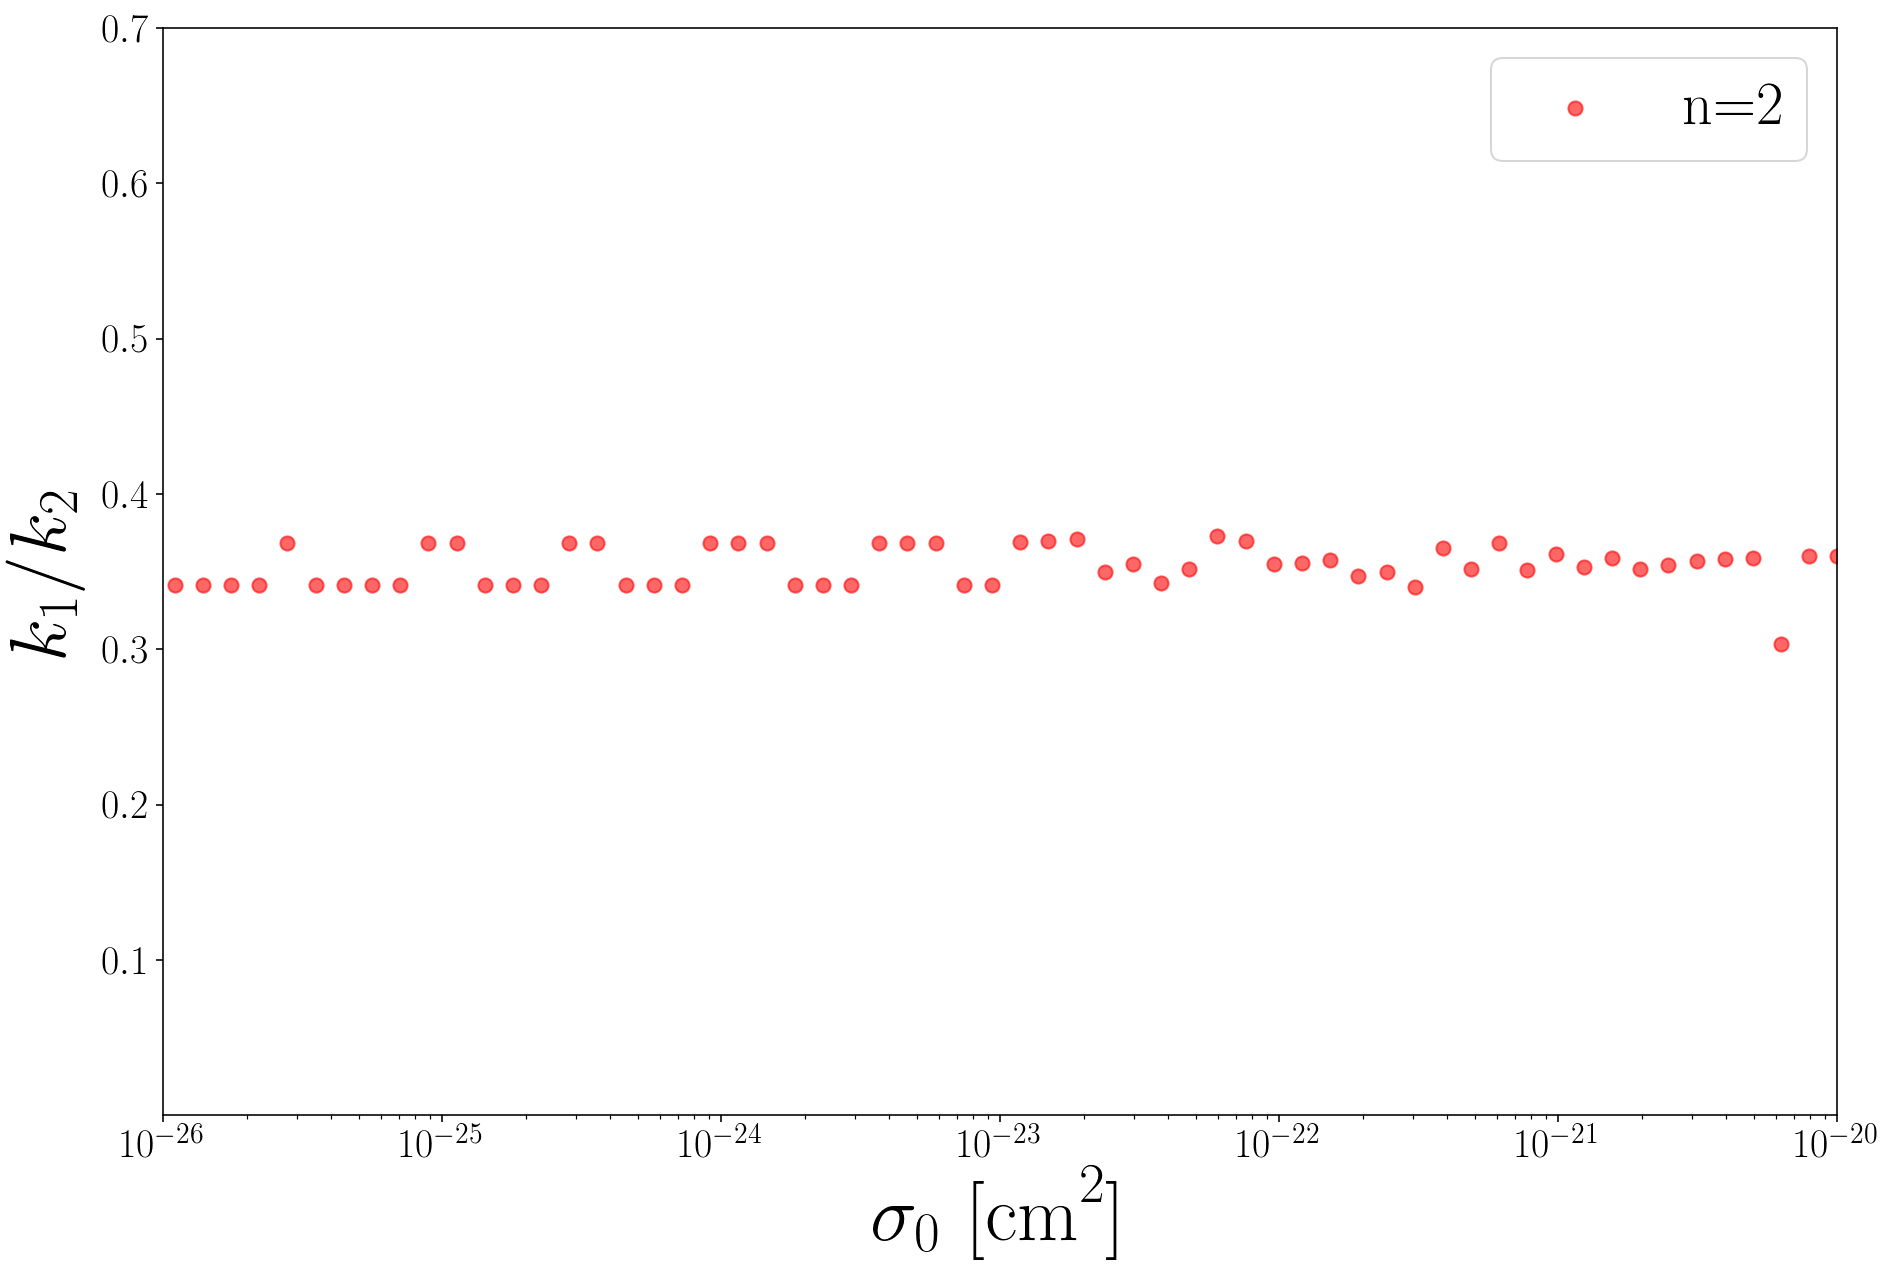

In [35]:
plt.figure(figsize=(15,10))    

plt.scatter(sigs_2,k1_2/k2_2,s=50,color='red',alpha=0.6,label='n=2')
# plt.scatter(sigs_4,k1_4/k2_4,s=50,color='b',alpha=0.6,label='n=4')
# plt.scatter(sigs_6,k1_6/k2_6,s=50,color='orange',alpha=0.6,label='n=6')

plt.xscale('log')
plt.xlim(1e-26,1e-20)
plt.ylim(0,0.7)
plt.xlabel("$\sigma_0$"+r"$\textrm{ [cm}^2]$",fontsize=40)
plt.ylabel('$k_1/k_2$',fontsize=40)
plt.xticks(fontsize=20)
plt.yticks([0.10,0.20,0.30,0.40,0.50,0.60,0.70],fontsize=20)
plt.legend(fontsize=30)

---

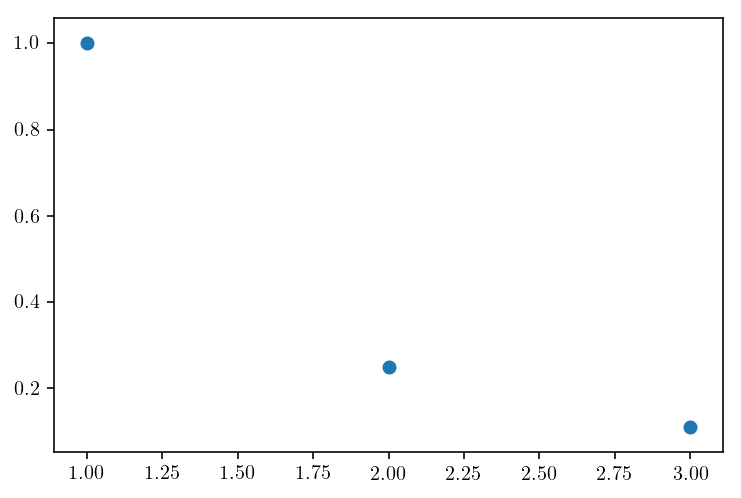

In [56]:
x = np.array([1.,2.,3.])
plt.scatter(x,pow(1/x,2))

### $\delta_{tk}$

In [ ]:
def dtk(npow=0,m=1,sigmas=smallSigs,z='z1',
       pk_root='class/pk_output/',
        filename=None,lcdm_filename='lcdm_z1_pk.dat',label='',
       f=None,ax=None,xmin=0,xmax=20,ymin=-1.0,ymax=1e3,
       show_kcut=True,pfit=None, relative=True,boost_factor=1.):
    
    data0 = np.loadtxt(pk_root + lcdm_filename)
    ks = data0[:,0]
    pk0 = data0[:,1]
    
    if filename is None:
        for i,sigma in enumerate(sigmas):
            if i == 0:
                continue
                
            filename = pk_root + 'n{}_m{}_s{}_{}_tk.dat'.format(npow,m,sigma,z)
            np.loadtxt(filename)
            data = np.loadtxt(filename)
            
            ks = data[:,0]
            dg = data[:,1]
            db = data[:,2]
            ddmeff = data[:,3]
            dur = data[:,4]
            dtot = data[:,5]
            
            df = pd.DataFrame({'k':ks,'dg':dg,'db':db,'ddmeff':ddmeff,'dtot':dtot})
    return df

In [ ]:
df = dtk(npow=2)
df[df.k>35]

$..................................................................................$

$..................................................................................$

$..................................................................................$

In [29]:
def transfer(k,mwdm):
    nu = 1.12
    lambda_fs = (0.049*(mwdm**(-1.11))\
                 *((Omega_m/0.25)**(0.11))*((h/0.7)**1.22))
    alpha = lambda_fs
    transfer = (1+(alpha*k)**(2*nu))**(-5./nu)
    return transfer

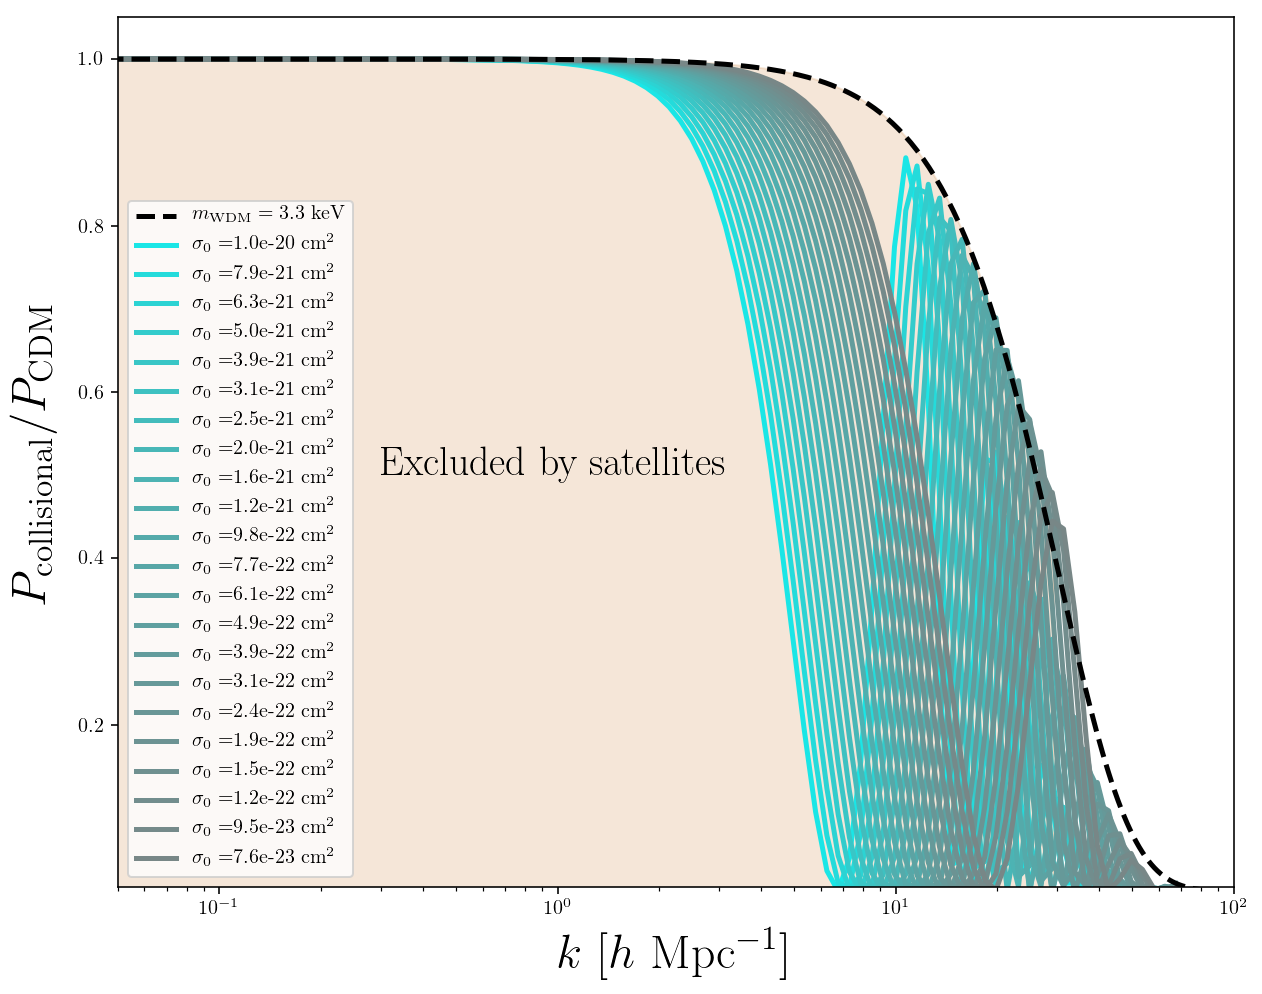

In [30]:
ks = np.logspace(-5,4,1000)

plt.figure(figsize=(10,8))
plt.semilogx(ks,transfer(ks,3.3)**2,linestyle='--',label=r'$m_{\rm{WDM}} = 3.3\ \rm{keV}$',c='k',lw=2.5,zorder=998)
k1_2,k2_2,sigs_2 = show_pk(npow=6,label="n=2")
plt.xlim(0.05,1e2)
plt.ylim(0.005,1.05)
plt.ylabel(r'$P_{\rm{collisional}}/P_{\rm{CDM}}$',fontsize=24,labelpad=8)
plt.xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=24)
plt.legend()
# plt.xticks([1e-1,1e0,1e1,5e1,1e2,1e3,1e4])
# plt.yticks([0.05,0.25,0.5,0.75,1.0])
plt.text(0.3,0.5,"Excluded by satellites",fontsize=20)
plt.fill_between(np.logspace(-5,4,1000), 0, transfer(ks,3.3)**2,np.logspace(-5,4,1000) <=30,color='peru',alpha=0.2)

In [536]:
lcdm_filename='lcdm_z1_pk.dat'
pk_root='class/pk_output/'
data0 = np.loadtxt(pk_root + lcdm_filename)
ks = data0[:,0]
pk0 = data0[:,1]
npow=4
m=0.0001
sigmas=smallSigs

k_peaks = []
tk_peaks = []
sigggs = []
for i,sigma in enumerate(sigmas):

    # pk data from class for given mass, sigma, power
    filename = pk_root + 'n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)
    np.loadtxt(filename)
    data = np.loadtxt(filename)
    pk = data[:,1]

    # determine peaks/troughs of transfer
    a = pk/pk0
    mins = findLocalMins(a)
    maxs = findLocalMaxs(a)

    k_peaks1D = [[],[],[]]
    tk_peaks1D = [[],[],[]]
    k=0        
    for j in range(len(maxs)):
        k_peaks1D[k].append(ks[maxs[j]])
        tk_peaks1D[k].append(pk[maxs[j]]/pk0[maxs[j]])
        if j != len(maxs)-1:
            if maxs[j+1]-maxs[j]>2:
                k+=1
                
    for l in range(k+1):
        if k_peaks1D[l]:
            k_peaks1D[l] = np.average(k_peaks1D[l])
            tk_peaks1D[l] = np.average(tk_peaks1D[l])  

    k_peaks.append(k_peaks1D)
    tk_peaks.append(tk_peaks1D)
    sigggs.append(sigma)

(0, 1)

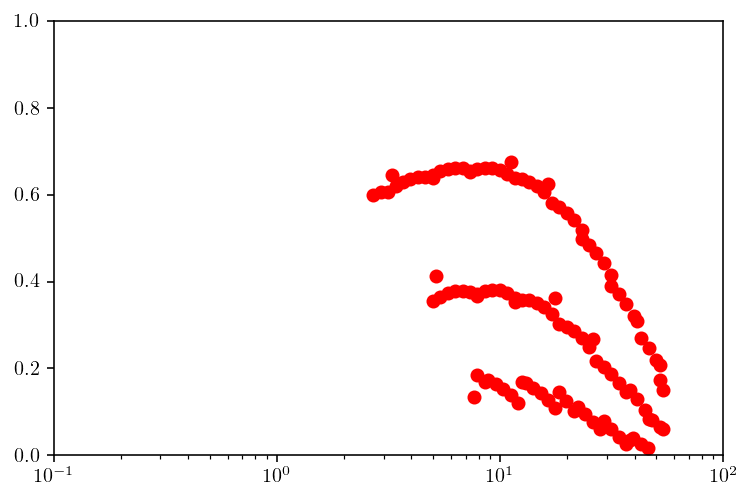

In [537]:
# k1_2,k2_2,sigs_2 = show_pk(npow=2,label="n=2")
for i in range(len(k_peaks)):
    for j in range(len(k_peaks[i])):
        plt.scatter(k_peaks[i][j],tk_peaks[i][j],c='r')

plt.xscale('log')
plt.xlim(1e-1,1e2)
plt.ylim(0,1)

(1e-26, 1e-20)

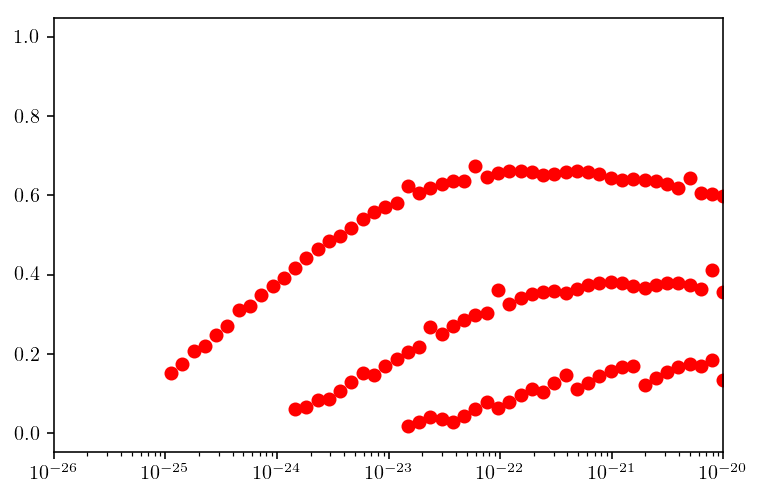

In [538]:
k1_2,k2_2,sigs_2 = show_pk(npow=2,label="n=2")
for i in range(len(tk_peaks)):
    for j in range(len(tk_peaks[i])):
        try: plt.scatter(sigggs[i],tk_peaks[i][j],c='r')
        except: continue

plt.xscale('log')
plt.xlim(1e-26,1e-20)
# plt.ylim(0,1)

In [533]:
relatives = []
for i in range(len(tk_peaks)):
    try: relatives.append([tk_peaks[i][0]/tk_peaks[i][1],
                           tk_peaks[i][1]/tk_peaks[i][2]])
    except: continue

(1e-26, 1e-20)

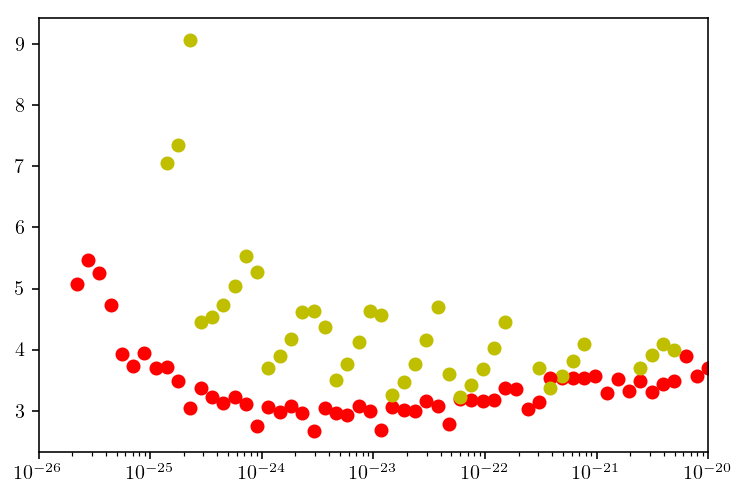

In [534]:
for i in range(len(relatives)):
    plt.scatter(sigggs[i],relatives[i][0],c='r')
    try: plt.scatter(sigggs[i],relatives[i][1],c='y')   
    except: continue
plt.xscale('log')
plt.xlim(1e-26,1e-20)

In [493]:
def func(x,a):
    return np.exp((-x/a))

In [485]:
relatives[3], sigggs[3]

([3.4843347191207794, 3.9955857494262164], 4.9770235643320935e-21)

In [481]:
np.exp(1e-20/7.7e-21)

3.664534440296432

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


(1e-26, 1e-20)

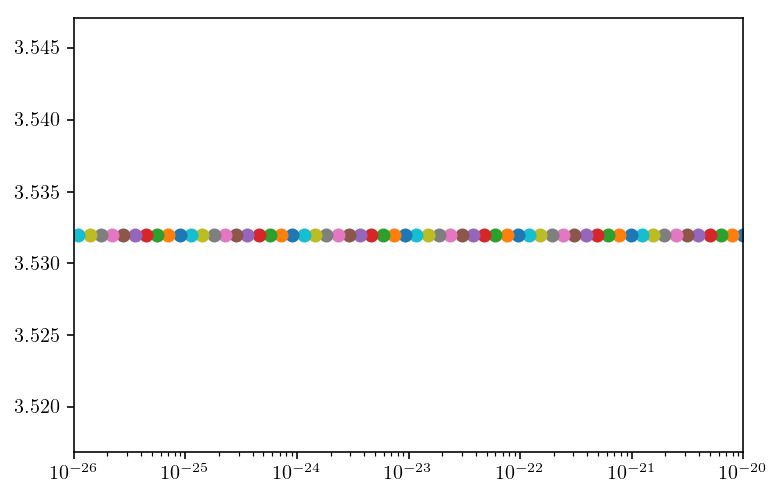

In [499]:
for i in range(len(sigggs)-1):
    print i
    plt.scatter(sigggs[i],func(-sigggs[i],sigggs[i+1]))
plt.xscale('log')
plt.xlim(1e-26,1e-20)    

# Other

#### Peak fitting

In [16]:
k1,tk1,s1 = vds0.peaks(npow=1)
k2,tk2,s2 = vds0.peaks(npow=2)
k3,tk3,s3 = vds0.peaks(npow=3)
k4,tk4,s4 = vds0.peaks(npow=4)
k5,tk5,s5 = vds0.peaks(npow=5)
k6,tk6,s6 = vds0.peaks(npow=6)
k8,tk8,s8 = vds0.peaks(npow=8)
k10,tk10,s10 = vds0.peaks(npow=10)

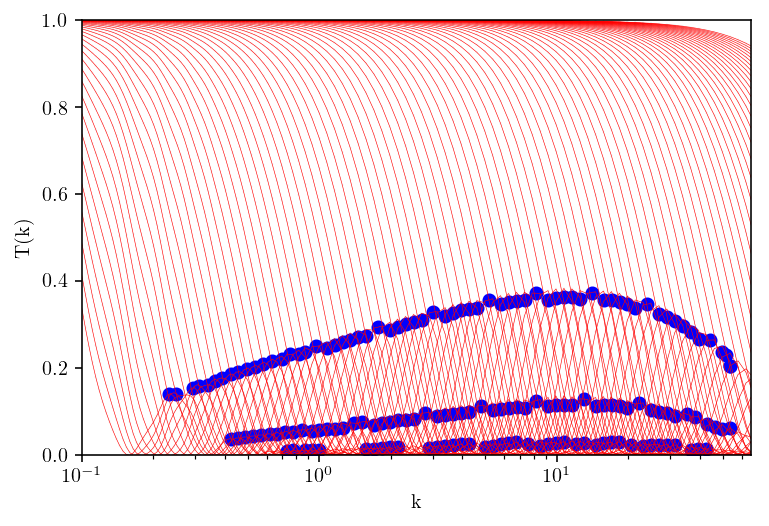

In [17]:
for i in range(len(tk2)):
    for j in range(len(tk2[i])):
        try: plt.scatter(k2[i][j],tk2[i][j],c='b')
        except: continue

plt.scatter(k2[0][0],tk2[0][0],c='b',label='n=2')
# plt.xscale('log')
plt.xlim(1e-1,66)
plt.ylim(0,1)
plt.xlabel("k")
plt.ylabel("T(k)")
# plt.legend()
vds0.all_sigmas(npow=2,m=0.0001,sigmas=smallSigs,lw=0.3)

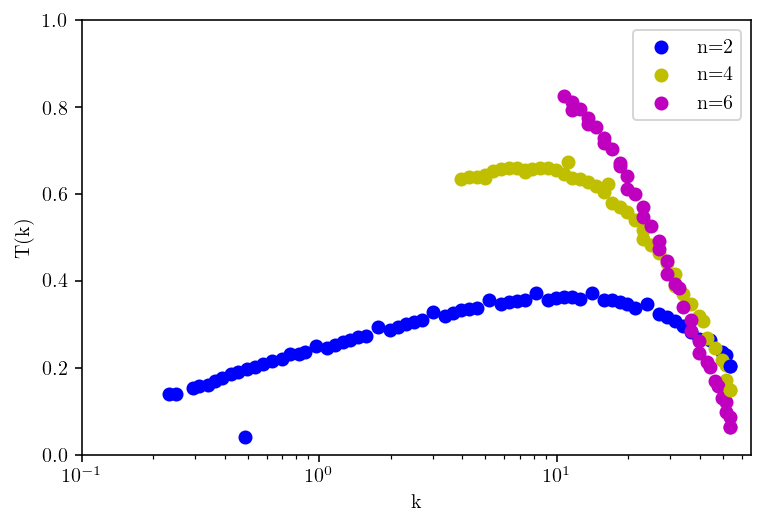

In [18]:
for i in range(len(tk2)):
    try: plt.scatter(k2[i][0],tk2[i][0],c='b')
    except: continue
for i in range(len(tk4)):
    try: plt.scatter(k4[i][0],tk4[i][0],c='y')
    except: continue
for i in range(len(tk6)):
    try: plt.scatter(k6[i][0],tk6[i][0],c='m')
    except: continue  

plt.scatter(k2[0][0],tk2[0][0],c='b',label="n=2")
plt.scatter(k4[0][0],tk4[0][0],c='y',label="n=4")
plt.scatter(k6[0][0],tk6[0][0],c='m',label="n=6")

plt.xscale('log')
plt.xlim(1e-1,66)
plt.ylim(0,1)
plt.xlabel("k")
plt.ylabel("T(k)")
plt.legend()
# vds0.all_sigmas(npow=2,m=0.0001,sigmas=smallSigs,lw=0.3)  
# vds0.all_sigmas(npow=4,m=0.0001,sigmas=smallSigs,lw=0.3)            
# vds0.all_sigmas(npow=6,m=0.0001,sigmas=smallSigs,lw=0.3)            

Fitting expression: $\frac{log(k+2.3)}{\alpha1.09^{kn/10}}$

In [19]:
params2 = [2.3,2,1.09,10]
params4 = [2.3,4,1.09,5]
params6 = [2.3,6,1.09,3.3]
params8 = [2.3,8.,1.09,2]

In [20]:
def logpow(x,a,npow,n,m):
    aa = (np.log(x)+a)/(m*np.power(n,(x*npow)/10))
    return (aa)

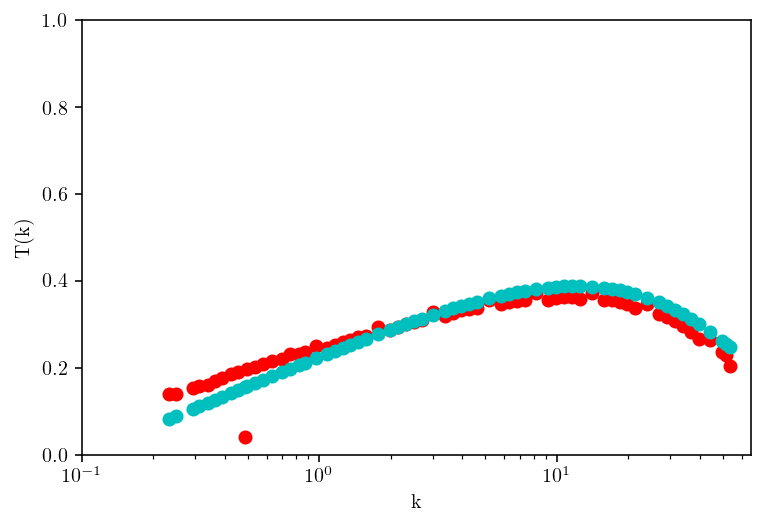

In [21]:
for i in range(len(tk2)):
    plt.scatter(k2[i][0],tk2[i][0],c='r')
for i in range(len(tk2)):
    plt.scatter([row[0] for row in k2][i],logpow(np.array([row[0] for row in k2][i]),*params2),c='c')
plt.xlim(1e-1,66)
plt.ylim(0,1)
plt.xlabel("k")
plt.ylabel("T(k)")
plt.xscale('log')

Text(0.11,-0.1,'Plot of first peak amplitude for n=1,2,4,6 (black=1 ...\n magenta=6) at similar $\\sigma_0$ (8e-21). Larger ns are further\n along in evolution')

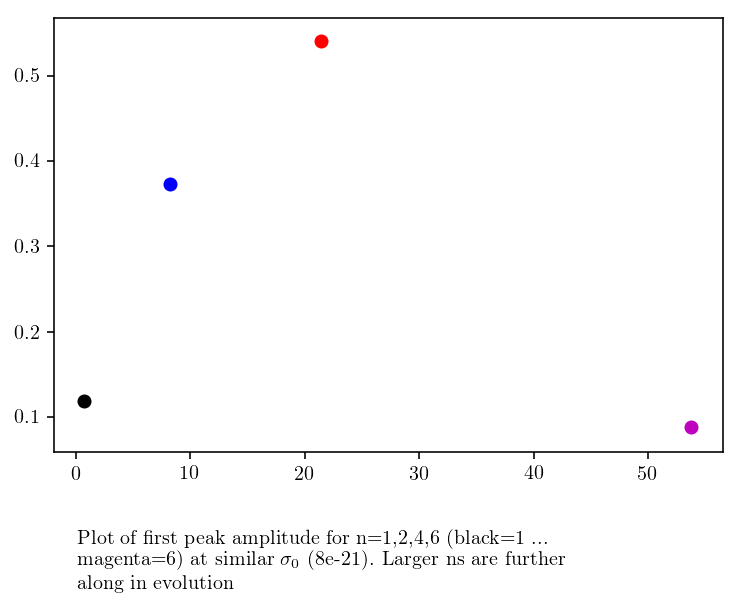

In [22]:
plt.scatter(k1[3][0],tk1[3][0],c='k',label='n1')
plt.scatter(k2[22][0],tk2[22][0],c='b',label='n2')
plt.scatter(k4[17][0],tk4[17][0],c='r',label='n4')
plt.scatter(k6[1][0],tk6[1][0],c='m',label='n6')
plt.text(1.1e-1,-0.1,"Plot of first peak amplitude for n=1,2,4,6 (black=1 ...\n magenta=6) at similar $\sigma_0$ (8e-21). Larger ns are further\n along in evolution")

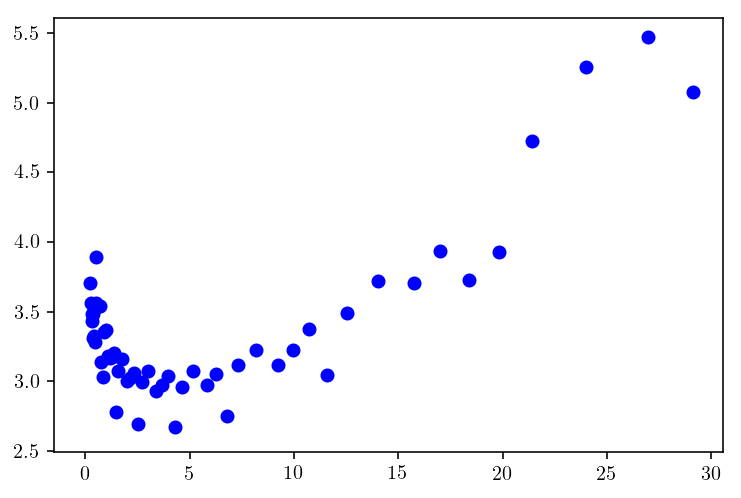

In [23]:
relatives = []
for i in range(len(tk2)):
    relatives.append([tk2[i][0]/tk2[i][1]])
for i in range(len(relatives)):
    try: plt.scatter(k2[i][0],relatives[i][0],c='b')
    except: continue

#### Thomson scattering rate

In [32]:
n2_limits

,$\sigma_0$ analytical ($cm^2$),$\sigma_0$ super conservative ($cm^2$),Mass (GeV)
0,1.846425e-27,3.500000e-26,0.0001
1,3.370064e-25,1.500000e-23,0.0100
2,4.347013e-23,9.800000e-22,1.0000


In [64]:
vds0.z_kin(1.8e-27,0.0001,2)

array([4588277.22300078])

In [328]:
z = np.logspace(0,10,100)
z1 = np.logspace(np.log10(zth)/10,np.log10(zth))
z2 = np.logspace(np.log10(zth),np.log10(zth)+5,500)

plt.plot(z,vds0.aH(z,1.8e-27,0.0001,2),label="aH")
plt.plot(z1,vds0.Rx_kin(z1,1.8e-27,0.0001,2),label="Rkin")
plt.plot(z2,vds0.Rx_th(z2,1.8e-27,0.0001,2),label="Rth")
plt.plot(z,vds0.Rgamma(z),label="Rg")
plt.xlim(1e6,6e10)
# plt.ylim(1e2,1e8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z')
plt.text(1.5e6,1e-10,"$n=2$\n$m=100$ keV")
plt.legend()

NameError: name 'zth' is not defined

In [ ]:
   def findLocalMins(self,arr):
        mins = []
        i=0
        while i < len(arr):
            try:
                if (arr[i-3]-arr[i])>0.01 and (arr[i+3]-arr[i])>0.01:
                    mins.append(i)
                    i+=3
                i+=1
            except:
                i+=1
                continue
        return mins
    
    def findLocalMaxs(self,arr):
        maxs = []
        i=0
        while i < len(arr):
            try:
                if (arr[i]-arr[i-3])>0.01 and (arr[i]-arr[i+3])>0.01:
                    maxs.append(i)
                i+=1
            except:
                i+=1
                continue
        return maxs
    
    def peaks(self,npow=2,m=0.0001,sigmas=np.logspace(-30,-20,100)):
    
        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        k_peaks = []
        tk_peaks = []
        sigggs = []

        for i,sigma in enumerate(sigmas):
            try:
                # pk data from class for given mass, sigma, power
                filename = 'class/pk_output/' + 'n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)
                np.loadtxt(filename)
                data = np.loadtxt(filename)
                pk = data[:,1]

                # determine peaks/troughs of transfer
                a = pk/pk0
                mins = self.findLocalMins(a)
                maxs = self.findLocalMaxs(a)

                k_peaks1D = [[],[],[]]
                tk_peaks1D = [[],[],[]]
                k=0        
                for j in range(len(maxs)):
                    k_peaks1D[k].append(ks[maxs[j]])
                    tk_peaks1D[k].append(pk[maxs[j]]/pk0[maxs[j]])
                    if j != len(maxs)-1:
                        if maxs[j+1]-maxs[j]>2:
                            k+=1

                for l in range(k+1):
                    if k_peaks1D[l]:
                        k_peaks1D[l] = np.average(k_peaks1D[l])
                        tk_peaks1D[l] = np.average(tk_peaks1D[l])  

                if k_peaks1D[0]:     
                    k_peaks.append(k_peaks1D)
                    tk_peaks.append(tk_peaks1D)
                    sigggs.append(sigma)

            except: continue
        return k_peaks, tk_peaks, sigggs# Other

#### Peak fitting

k1,tk1,s1 = vds0.peaks(npow=1)
k2,tk2,s2 = vds0.peaks(npow=2)
k3,tk3,s3 = vds0.peaks(npow=3)
k4,tk4,s4 = vds0.peaks(npow=4)
k5,tk5,s5 = vds0.peaks(npow=5)
k6,tk6,s6 = vds0.peaks(npow=6)
k8,tk8,s8 = vds0.peaks(npow=8)
k10,tk10,s10 = vds0.peaks(npow=10)

for i in range(len(tk2)):
    for j in range(len(tk2[i])):
        try: plt.scatter(k2[i][j],tk2[i][j],c='b')
        except: continue

plt.scatter(k2[0][0],tk2[0][0],c='b',label='n=2')
# plt.xscale('log')
plt.xlim(1e-1,66)
plt.ylim(0,1)
plt.xlabel("k")
plt.ylabel("T(k)")
# plt.legend()
vds0.all_sigmas(npow=2,m=0.0001,sigmas=smallSigs,lw=0.3)

for i in range(len(tk2)):
    try: plt.scatter(k2[i][0],tk2[i][0],c='b')
    except: continue
for i in range(len(tk4)):
    try: plt.scatter(k4[i][0],tk4[i][0],c='y')
    except: continue
for i in range(len(tk6)):
    try: plt.scatter(k6[i][0],tk6[i][0],c='m')
    except: continue  

plt.scatter(k2[0][0],tk2[0][0],c='b',label="n=2")
plt.scatter(k4[0][0],tk4[0][0],c='y',label="n=4")
plt.scatter(k6[0][0],tk6[0][0],c='m',label="n=6")

plt.xscale('log')
plt.xlim(1e-1,66)
plt.ylim(0,1)
plt.xlabel("k")
plt.ylabel("T(k)")
plt.legend()
# vds0.all_sigmas(npow=2,m=0.0001,sigmas=smallSigs,lw=0.3)  
# vds0.all_sigmas(npow=4,m=0.0001,sigmas=smallSigs,lw=0.3)            
# vds0.all_sigmas(npow=6,m=0.0001,sigmas=smallSigs,lw=0.3)            

Fitting expression: $\frac{log(k+2.3)}{\alpha1.09^{kn/10}}$

params2 = [2.3,2,1.09,10]
params4 = [2.3,4,1.09,5]
params6 = [2.3,6,1.09,3.3]
params8 = [2.3,8.,1.09,2]

def logpow(x,a,npow,n,m):
    aa = (np.log(x)+a)/(m*np.power(n,(x*npow)/10))
    return (aa)

for i in range(len(tk2)):
    plt.scatter(k2[i][0],tk2[i][0],c='r')
for i in range(len(tk2)):
    plt.scatter([row[0] for row in k2][i],logpow(np.array([row[0] for row in k2][i]),*params2),c='c')
plt.xlim(1e-1,66)
plt.ylim(0,1)
plt.xlabel("k")
plt.ylabel("T(k)")
plt.xscale('log')

plt.scatter(k1[3][0],tk1[3][0],c='k',label='n1')
plt.scatter(k2[22][0],tk2[22][0],c='b',label='n2')
plt.scatter(k4[17][0],tk4[17][0],c='r',label='n4')
plt.scatter(k6[1][0],tk6[1][0],c='m',label='n6')
plt.text(1.1e-1,-0.1,"Plot of first peak amplitude for n=1,2,4,6 (black=1 ...\n magenta=6) at similar $\sigma_0$ (8e-21). Larger ns are further\n along in evolution")

relatives = []
for i in range(len(tk2)):
    relatives.append([tk2[i][0]/tk2[i][1]])
for i in range(len(relatives)):
    try: plt.scatter(k2[i][0],relatives[i][0],c='b')
    except: continue

#### Thomson scattering rate

n2_limits

vds0.z_kin(1.8e-27,0.0001,2)

z = np.logspace(0,10,100)
z1 = np.logspace(np.log10(zth)/10,np.log10(zth))
z2 = np.logspace(np.log10(zth),np.log10(zth)+5,500)

plt.plot(z,vds0.aH(z,1.8e-27,0.0001,2),label="aH")
plt.plot(z1,vds0.Rx_kin(z1,1.8e-27,0.0001,2),label="Rkin")
plt.plot(z2,vds0.Rx_th(z2,1.8e-27,0.0001,2),label="Rth")
plt.plot(z,vds0.Rgamma(z),label="Rg")
plt.xlim(1e6,6e10)
# plt.ylim(1e2,1e8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z')
plt.text(1.5e6,1e-10,"$n=2$\n$m=100$ keV")
plt.legend()

5.214008287999674e-29
1.6681005372000557e-28
1.3530477745798075e-27
1.6297508346206403e-29
5.214008287999674e-29
3.351602650938848e-28


<Figure size 2250x1500 with 0 Axes>

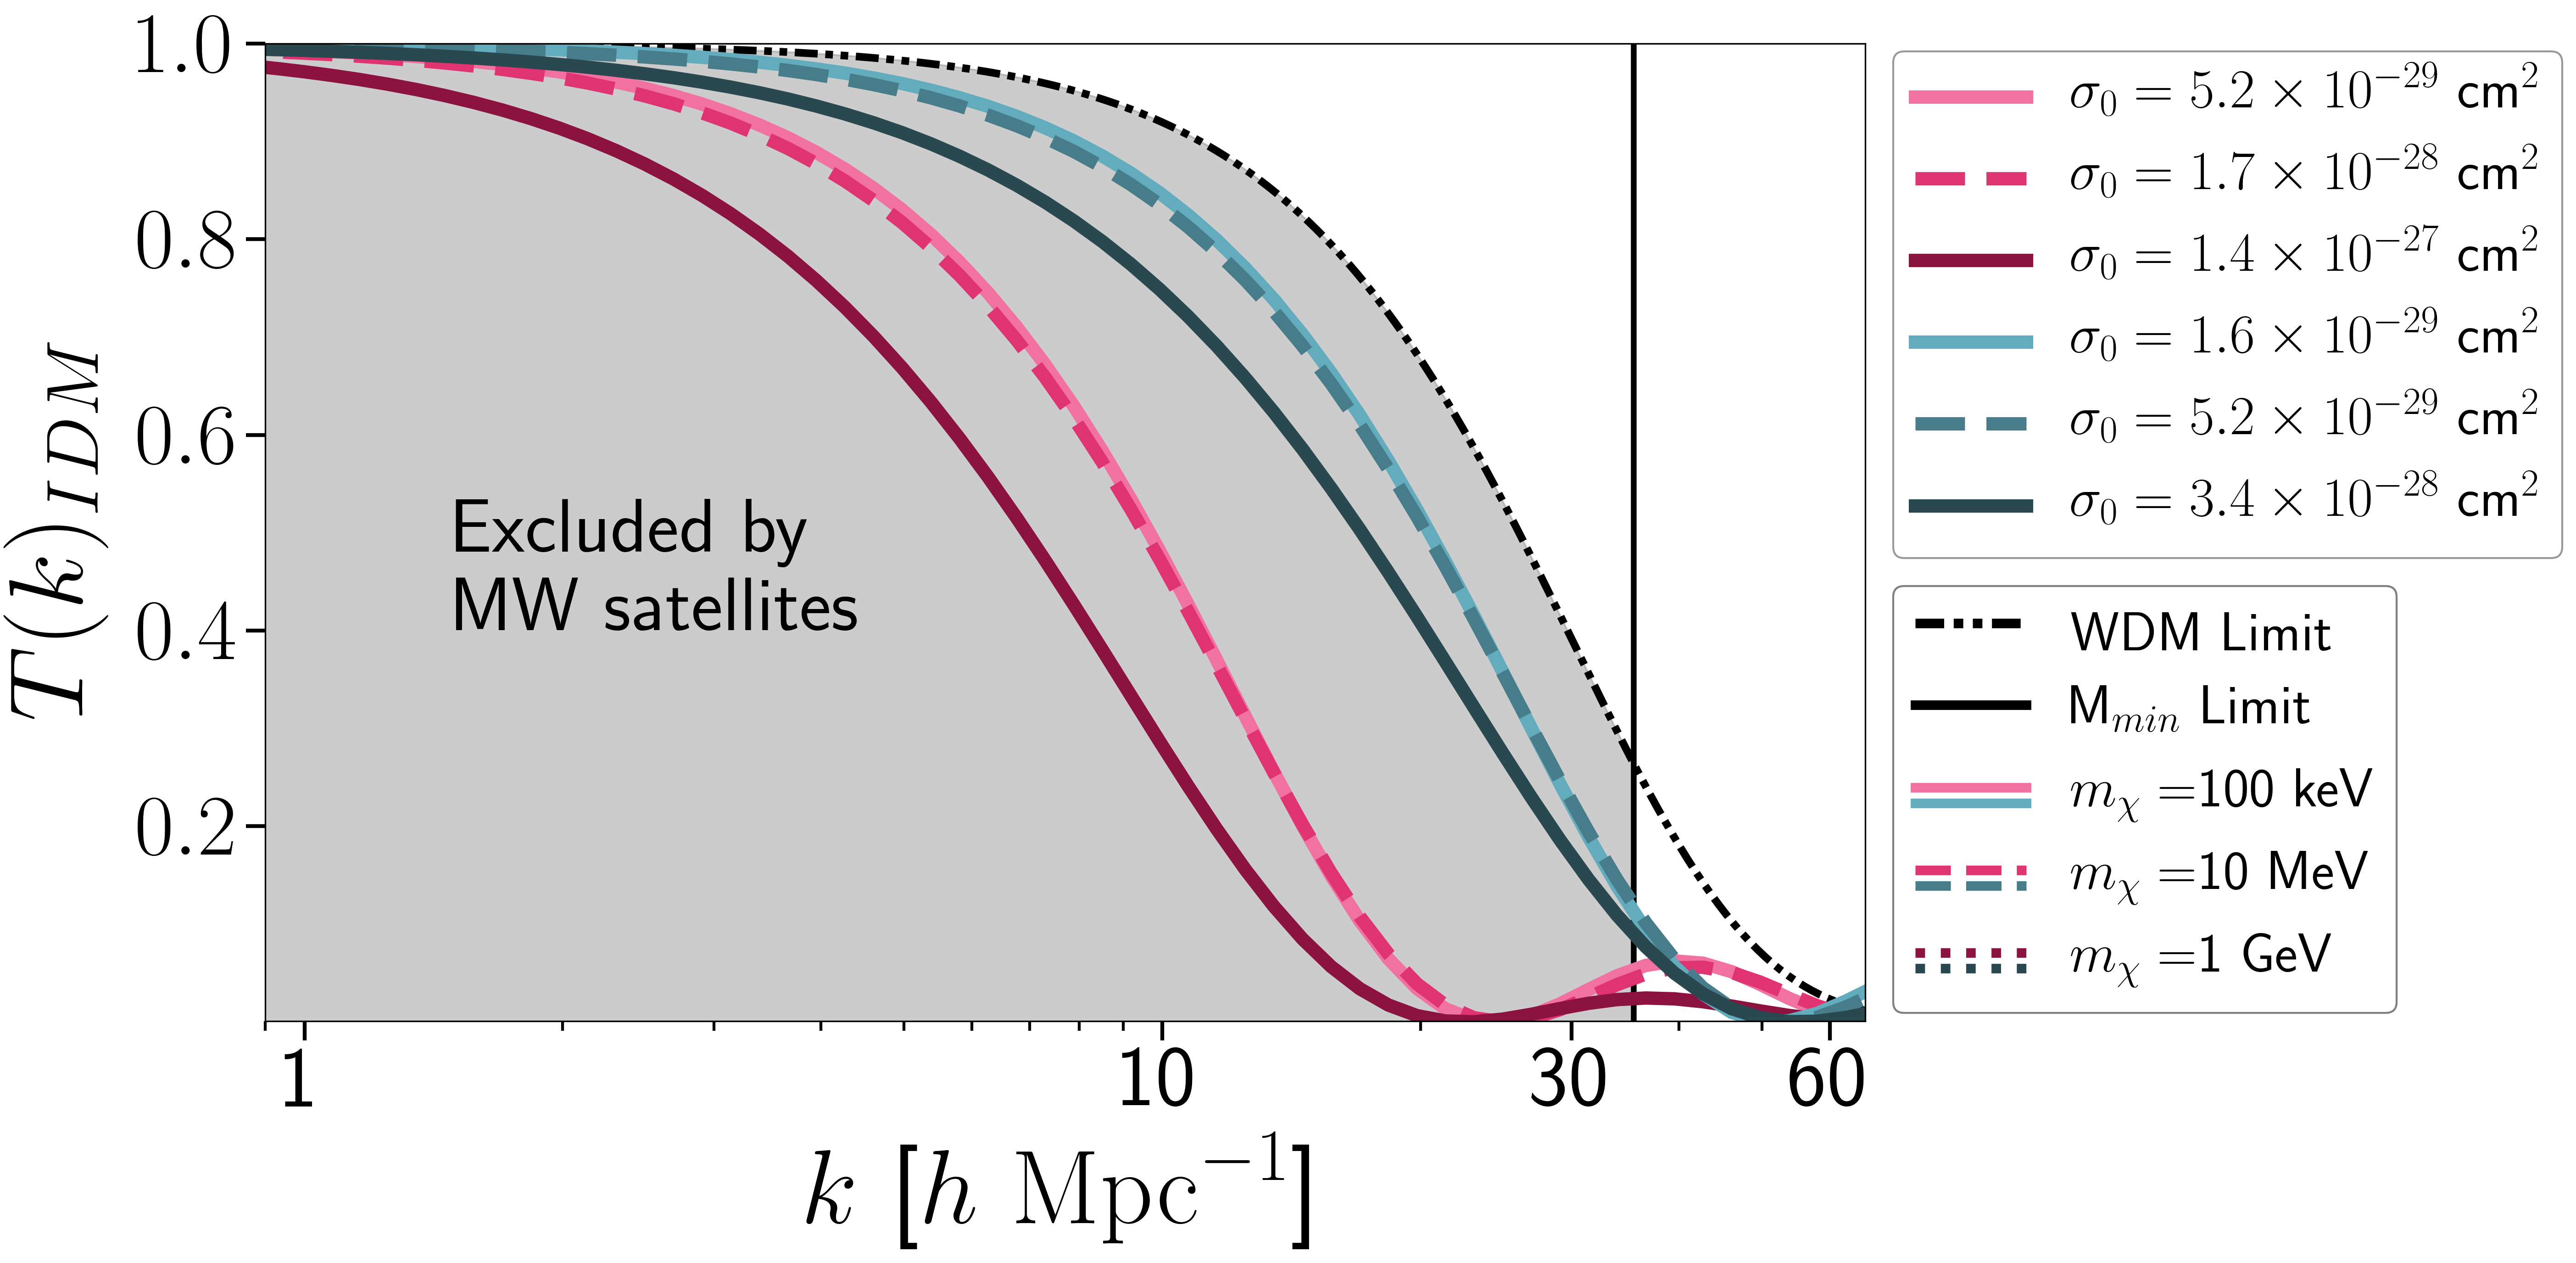

In [9]:
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, hand,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                           ls=hand[0], c=hand[1],lw=5)
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                           ls=hand[0],c=hand[2],lw=5)
        return [l1, l2]
    
plt.figure(figsize=(15,10))
fig, ax = plt.subplots(figsize=(15,10))

ks2 = np.logspace(-5,4,1000)
plt.semilogx(ks2,vds0.transfer(ks2,3.3)**2,linestyle=(0, (3, 1, 1, 1, 1, 1)),c='k',lw=4)
plt.axvline(klim,c='k',ls='-',lw=3)
plt.fill_between(np.logspace(-5,4,1000), -10, vds0.transfer(ks2,3.3)**2,where=np.logspace(-5,4,1000)<36,color='grey',alpha=0.4)

tk_idm_c100,ks,sigma0 = vds0.single_tk(npow=0,m=0.0001,c='#F172A0',label=r'$\sigma_0=5.2\times 10^{-29}$ cm$^2$',ls='-',sigmas=smallSigs,index=82,lw=7)
tk_idm_c10,ks,sigma0 = vds0.single_tk(npow=0,m=0.01,c='#E03372',label=r'$\sigma_0=1.7\times 10^{-28}$ cm$^2$',ls='--',sigmas=smallSigs,index=77,lw=7)
tk_idm_c1,ks,sigma0 = vds0.single_tk(npow=0,m=1,c='#8C123F',label=r'$\sigma_0=1.4\times 10^{-27}$ cm$^2$',ls='-',sigmas=smallSigs,index=68,lw=7)
tk_idm_a,ks,sigma0 = vds0.single_tk(npow=0,m=0.0001,c='#63acbe',label=r'$\sigma_0=1.6\times 10^{-29}$ cm$^2$',ls='-',sigmas=smallSigs,index=87,lw=7)
tk_idm_a,ks,sigma0 = vds0.single_tk(npow=0,m=0.01,c='#477D8A',label=r'$\sigma_0=5.2\times 10^{-29}$ cm$^2$',ls='--',sigmas=smallSigs,index=82,lw=7)
tk_idm_a,ks,sigma0 = vds0.single_tk(npow=0,m=1,c='#294850',label=r'$\sigma_0=3.4\times 10^{-28}$ cm$^2$',ls='-',sigmas=smallSigs,index=74,lw=7)
# plt.text(1,0.06,"$n=0$",fontsize=40)

# tk_idm_c,ks,sigma0 = vds0.single_tk(npow=2,m=0.0001,c='#F172A0',label=r'$\sigma_0=5.2\times 10^{-29}$ cm$^2$',ls='-',sigmas=smallSigs,index=54,lw=7)
# tk_idm_c,ks,sigma0 = vds0.single_tk(npow=2,m=0.01,c='#E03372',label=r'$\sigma_0=5.2\times 10^{-29}$ cm$^2$',ls='--',sigmas=smallSigs,index=28,lw=7)
# tk_idm_c,ks,sigma0 = vds0.single_tk(npow=2,m=1,c='#8C123F',label=r'$\sigma_0=5.2\times 10^{-29}$ cm$^2$',ls='--',sigmas=smallSigs,index=10,lw=7)
# tk_idm_a,ks,sigma0 = vds0.single_tk(npow=2,m=0.0001,c='#63acbe',label=r'$\sigma_0=5.2\times 10^{-29}$ cm$^2$',ls='-',sigmas=smallSigs,index=68,lw=7)
# tk_idm_a,ks,sigma0 = vds0.single_tk(npow=2,m=0.01,c='#477D8A',label=r'$\sigma_0=5.2\times 10^{-29}$ cm$^2$',ls='--',sigmas=smallSigs,index=45,lw=7)
# tk_idm_a,ks,sigma0 = vds0.single_tk(npow=2,m=1,c='#294850',label=r'$\sigma_0=5.2\times 10^{-29}$ cm$^2$',ls='--',sigmas=smallSigs,index=25,lw=7)
# plt.text(1,0.06,"$n=2$",fontsize=40)

# tk_idm_c100,ks,sigma0 = vds0.single_tk(npow=0,m=0.0001,c='#F172A0',label=r'$\sigma_0=5.2\times 10^{-29}$ cm$^2$',ls='-',sigmas=smallSigs,index=82,lw=7)
# tk_idm_c10,ks,sigma0 = vds0.single_tk(npow=0,m=0.01,c='#E03372',label=r'$\sigma_0=1.7\times 10^{-28}$ cm$^2$',ls='--',sigmas=smallSigs,index=77,lw=7)
# tk_idm_c,ks,sigma0 = vds0.single_tk(npow=4,m=1,c='#D81B60',label='c',ls=':',sigmas=np.logspace(-10,-30,30),index=7,lw=7)
# tk_idm_a,ks,sigma0 = vds0.single_tk(npow=0,m=0.0001,c='#63acbe',label=r'$\sigma_0=1.6\times 10^{-29}$ cm$^2$',ls='-',sigmas=smallSigs,index=87,lw=7)
# tk_idm_a,ks,sigma0 = vds0.single_tk(npow=0,m=0.01,c='#477D8A',label=r'$\sigma_0=5.2\times 10^{-29}$ cm$^2$',ls='--',sigmas=smallSigs,index=82,lw=7)
# tk_idm_a,ks,sigma0 = vds0.single_tk(npow=4,m=1,c='#D81B60',label='c',ls=':',sigmas=smallSigs2,index=6,lw=7)
# plt.text(1,0.06,"$n=4$",fontsize=40)

# tk_idm_c100,ks,sigma0 = vds0.single_tk(npow=0,m=0.0001,c='#F172A0',label=r'$\sigma_0=5.2\times 10^{-29}$ cm$^2$',ls='-',sigmas=smallSigs,index=82,lw=7)
# tk_idm_c10,ks,sigma0 = vds0.single_tk(npow=0,m=0.01,c='#E03372',label=r'$\sigma_0=1.7\times 10^{-28}$ cm$^2$',ls='--',sigmas=smallSigs,index=77,lw=7)
# tk_idm_c,ks,sigma0 = vds0.single_tk(npow=6,m=1,c='#D81B60',label='c',ls='-.',sigmas=np.logspace(-5,-30,100),index=15,lw=7)
# tk_idm_a,ks,sigma0 = vds0.single_tk(npow=0,m=0.0001,c='#63acbe',label=r'$\sigma_0=1.6\times 10^{-29}$ cm$^2$',ls='-',sigmas=smallSigs,index=87,lw=7)
# tk_idm_a,ks,sigma0 = vds0.single_tk(npow=0,m=0.01,c='#477D8A',label=r'$\sigma_0=5.2\times 10^{-29}$ cm$^2$',ls='--',sigmas=smallSigs,index=82,lw=7)
# tk_idm_a,ks,sigma0 = vds0.single_tk(npow=6,m=1,c='#D81B60',label='c',ls='-.',sigmas=largeSigs,index=15,lw=7)
# plt.text(1,0.06,"$n=6$",fontsize=40)

plt.text(1.5,0.4,"Excluded by\nMW satellites",fontsize=40)
plt.xscale("log")
plt.xlim(0.9,66)
plt.xticks([1,10,30,60],["1","10","30","60"])
plt.ylim(0.001,1)
plt.ylabel(r'$T(k)_{IDM}$',fontsize=55,labelpad=10)
plt.xlabel(r'$k$ [$h\ \rm{Mpc}^{-1}$]',fontsize=55,labelpad=5)
plt.tick_params(labelsize=45,length=10,width=2)
plt.tick_params(which='minor',length=5,width=1.5)
ax.add_artist(plt.legend(edgecolor='grey',fontsize=29,loc='upper left',bbox_to_anchor=(1, 1.02)))
ax.add_artist(plt.legend([((0, (3, 1, 1, 1, 1, 1)),'k','none'),('-','k','none'), ('-','#F172A0','#63acbe'), ('--','#E03372','#477D8A'), (':','#8C123F','#294850')], ["WDM Limit", r'M$_{min}$ Limit', r'$m_{\chi}=$100 keV', r'$m_{\chi}=$10 MeV', r'$m_{\chi}=$1 GeV'],
           handler_map={tuple: AnyObjectHandler()},
           fontsize=29,framealpha=1,edgecolor='grey',
           bbox_to_anchor=(1,-0.02), loc="lower left"))

plt.subplots_adjust(bottom=0.17)
plt.savefig('plots/exclusions/n2_all.png')